# Traffic-based Route Guidance Solution

## Import the Dependancies and Library

In [49]:
import random
import os

import pandas as pd
import numpy as np
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


## Data Preprocessing & Analyzing

1. Load the VicRoads Boroondara dataset (.csv)

2. Clean and preprocess:
    * Convert timestamps

    * Handle missing values

    * Normalize/scale traffic flow values

3. Reshape for time-series forecasting (e.g., sequences of past 1-2 hours to predict next 15-min slot)

### Import the Dataset for analyze

In [50]:
main_dataset = pd.read_csv('https://raw.githubusercontent.com/yasirulokesha/IntroToAI-Assignment-2B/refs/heads/main/TBRGS/data/raw/Scats%20Data%20October%202006.csv', skiprows=1)

### Cluster and Make the Train and Test the Datasets

In [51]:
# Create time mapping for V00–V95 (15-minute intervals)
time_labels = [f"{h:02}:{m:02}:00" for h in range(24) for m in range(0, 60, 15)]
v_columns = [f"V{str(i).zfill(2)}" for i in range(96)]
time_map = dict(zip(v_columns, time_labels))

# Melt the V columns into long format
df_melted = main_dataset.melt(
    id_vars=["SCATS Number", "Location", "Date"],
    value_vars=v_columns,
    var_name="time_code",
    value_name="volume"
)

# Map time codes to actual time strings
df_melted['time_str'] = df_melted['time_code'].map(time_map)

# Combine Date and Time into a full timestamp
df_melted['timestamp'] = pd.to_datetime(df_melted['Date'] + ' ' + df_melted['time_str'], dayfirst=True)

# Rename columns for clarity
df_melted = df_melted.rename(columns={
    "SCATS Number": "site_id",
    "Location": "location"
})

# Select and reorder important columns
df_traffic = df_melted[["site_id", "location", "timestamp", "volume"]]

# 🔁 AGGREGATE: Sum volume over all directions at each site per timestamp
final_dataset = df_melted.groupby(['site_id', 'timestamp'])['volume'].sum().reset_index()

sites = final_dataset['site_id'].unique()

### Scaling the dataset using MinMaxScaler

### Breakdown the dataset for unique sites

### Data processing for ML

#### Create Time Series Sequences for Training and Testing purposes

In [52]:
# Define a function for creating sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

### Make the unique sequences for different sites

In [53]:
def generating_sequences(data_set):
    x, y = create_sequences(data_set, 96)
    x = x.reshape(-1, 96, 1)
    return x,y

### Drop Outliers

In [54]:
# Replace outliers using IQR
def replace_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the median
    median = df[column].median()
    df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)
    return df

## - Generating the models and save for predictions

In [55]:
for id in sites:
    print(id)
    site_data = final_dataset[final_dataset['site_id'] == id].sort_values("timestamp")
    
    replace_outliers_iqr(site_data, 'volume')
    
    # Scale Data
    scaler = MinMaxScaler()

    site_data['volume'] = scaler.fit_transform(site_data[['volume']])
    
    site_data = np.array(site_data['volume'])
    
    x, y = generating_sequences(site_data)
    
    # Split into training and testing
    split = int(len(x) * 0.8)
    X_train, X_test = x[:split], x[split:]
    Y_train, Y_test = y[:split], y[split:]
    
    # Define the LSTM model
    model = Sequential([
        Input(shape=(96, 1)),
        LSTM(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Train the model
    model.fit(
        X_train, Y_train,
        validation_data=(X_test, Y_test),
        epochs=20,
        batch_size=96,
        callbacks = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    )
    
    # Save the model
    model.save(f"../models/LSTM_models/lstm_model_site_{id}.keras")  # New format

    joblib.dump(scaler, f"../models/Scalers/scaler_site_{id}.save")

    print(f"\n✅ Model and scaler saved for site {id}.")


970
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2023 - mae: 0.3558 - val_loss: 0.0461 - val_mae: 0.1802
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0397 - mae: 0.1638 - val_loss: 0.0218 - val_mae: 0.1142
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0206 - mae: 0.1124 - val_loss: 0.0154 - val_mae: 0.0967
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0154 - mae: 0.0980 - val_loss: 0.0114 - val_mae: 0.0799
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0115 - mae: 0.0818 - val_loss: 0.0147 - val_mae: 0.1019
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0168 - mae: 0.1063 - val_loss: 0.0142 - val_mae: 0.0956
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0131 - mae: 0.0904 - val_loss: 0.0096 - val_mae: 0.0761
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0093 - mae: 0.0750 - val_loss: 0.0076 - val_mae: 0.0659
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0

In [59]:

# Replace outliers using IQR
replace_outliers_iqr(final_dataset, 'volume')

for id in sites:
    # Load the model and scaler
    model = load_model(f"../models/LSTM_models/lstm_model_site_{id}.keras")
    scaler = joblib.load(f"../models/Scalers/scaler_site_{id}.save")
    print(f"\n🚦 Loading model and scaler for site {id}...")
    
    # Filter data for this site
    site_data = final_dataset[final_dataset['site_id'] == id].sort_values("timestamp")
    
    site_data['volume'] = scaler.transform(site_data[['volume']])
    
    # Predictions for the next time step
    last_site_data = np.array(site_data['volume'][-96:]).reshape(-1, 96, 1)
   
    # Make predictions on the test set
    last_test_site_data = np.array(site_data['volume'][:97])
    
    testX, testY = generating_sequences(last_test_site_data)
    
    testX = testX.reshape(-1, 96, 1)
    
    # Make predictions on the test set
    y_pred = model.predict(testX)

    # Reverse scaling if necessary
    y_test_actual = scaler.inverse_transform(testY.reshape(-1, 1))
    y_pred_actual = scaler.inverse_transform(y_pred)

    smape = 100 * abs(y_pred_actual - y_test_actual) / ((abs(y_pred_actual) + abs(y_test_actual)) / 2)
    accuracy = 100 - smape
    accuracy = np.mean(accuracy)
    print(f"Accuracy: {accuracy:.2f}%")
    
    pred_scaled = model.predict(last_site_data)
    pred_volume = scaler.inverse_transform(pred_scaled)[0][0]

    # print(f"Predicted volume for the next time step: {pred_volume:.2f}")
    # print(pred_scaled)
    print(pred_volume)
    
    


🚦 Loading model and scaler for site 970...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Accuracy: 68.11%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
113.06418

🚦 Loading model and scaler for site 2000...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Accuracy: 62.64%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
252.54424

🚦 Loading model and scaler for site 2200...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Accuracy: 58.68%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
63.15565

🚦 Loading model and scaler for site 2820...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Accuracy: 72.38%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
44.789646

🚦 Loading model and scaler for site 2825...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Accuracy: 85.91%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
40.268204

🚦 Loading model and scaler for site 2827...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Accuracy: 72.80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
107.27153

🚦 Loading model and scaler for site 2846...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Accuracy: 49.62%
1/1 ━━━━━━━━━━

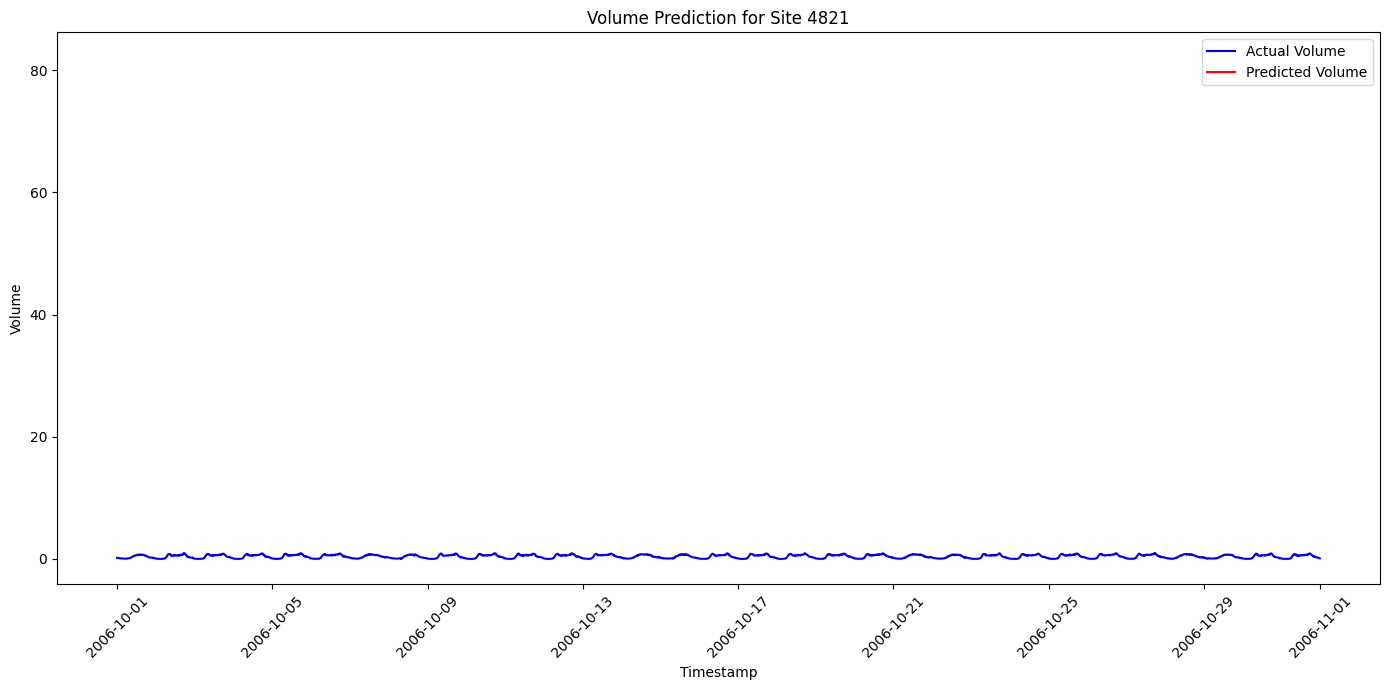

In [ ]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(site_data['timestamp'], site_data['volume'], label='Actual Volume', color='blue')
plt.plot(site_data['timestamp'][:len(y_pred)], pred_volume, label='Predicted Volume', color='red')

# plt.plot(site_data['timestamp'], y_pred_actual, label='Predicted Volume', color='red')
plt.title(f'Volume Prediction for Site {id}')
plt.xlabel('Timestamp')
plt.ylabel('Volume')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()